In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

# Define paths to your data
train_data_path = '/home/kundan/Documents/quantum/MY_data/train/'
test_data_path = '/home/kundan/Documents/quantum/MY_data/test/'

# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets using ImageFolder
train_dataset = datasets.ImageFolder(train_data_path, transform=transform)
test_dataset = datasets.ImageFolder(test_data_path, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check the class labels
print(train_dataset.classes)


['mango', 'orange']


In [3]:
class FruitClassifier(nn.Module):
    def __init__(self, num_classes):
        super(FruitClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 128 * 56 * 56)  # Adjust this according to your network architecture
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Initialize the model
model = FruitClassifier(num_classes=len(train_dataset.classes))


In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [6]:
num_epochs = 16

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

print("Finished Training")


Epoch [1/16], Loss: 0.0168
Epoch [2/16], Loss: 0.0070
Epoch [3/16], Loss: 0.0060
Epoch [4/16], Loss: 0.0049
Epoch [5/16], Loss: 0.0043
Epoch [6/16], Loss: 0.0041
Epoch [7/16], Loss: 0.0044
Epoch [8/16], Loss: 0.0040
Epoch [9/16], Loss: 0.0040
Epoch [10/16], Loss: 0.0040
Epoch [11/16], Loss: 0.0035
Epoch [12/16], Loss: 0.0034
Epoch [13/16], Loss: 0.0035
Epoch [14/16], Loss: 0.0035
Epoch [15/16], Loss: 0.0031
Epoch [16/16], Loss: 0.0031
Finished Training


In [7]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {100 * correct / total:.2f}%")


Accuracy on test set: 78.22%


In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import numpy as np

# Define paths to your data
train_data_path = '/home/kundan/Documents/quantum/MY_data/train/'
test_data_path = '/home/kundan/Documents/quantum/MY_data/test/'

# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets using ImageFolder
train_dataset = datasets.ImageFolder(train_data_path, transform=transform)
test_dataset = datasets.ImageFolder(test_data_path, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check the class labels
print(train_dataset.classes)

# Function to convert image tensors to numpy arrays
def convert_to_numpy(dataloader):
    images = []
    labels = []
    for data in dataloader:
        img, label = data
        img = img.numpy()
        img = img.reshape(img.shape[0], -1)  # Flatten the images
        images.append(img)
        labels.append(label)
    return np.concatenate(images), np.concatenate(labels)

# Convert train and test data to numpy arrays
x_train, y_train = convert_to_numpy(train_loader)
x_test, y_test = convert_to_numpy(test_loader)

# Normalize the data
x_train = (x_train - np.min(x_train)) / (np.max(x_train) - np.min(x_train))
x_test = (x_test - np.min(x_test)) / (np.max(x_test) - np.min(x_test))

# Ensure data dimensions are suitable for the quantum circuits
x_train = x_train[:, :8]
x_test = x_test[:, :8]


['mango', 'orange']


In [9]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN

# Define convolutional circuit
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

# Define convolutional layer
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

# Define pooling circuit
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    return target

# Define pooling layer
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

# Create feature map and ansatz
feature_map = ZFeatureMap(8)
ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

# Observable
observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# Decompose circuit for QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)


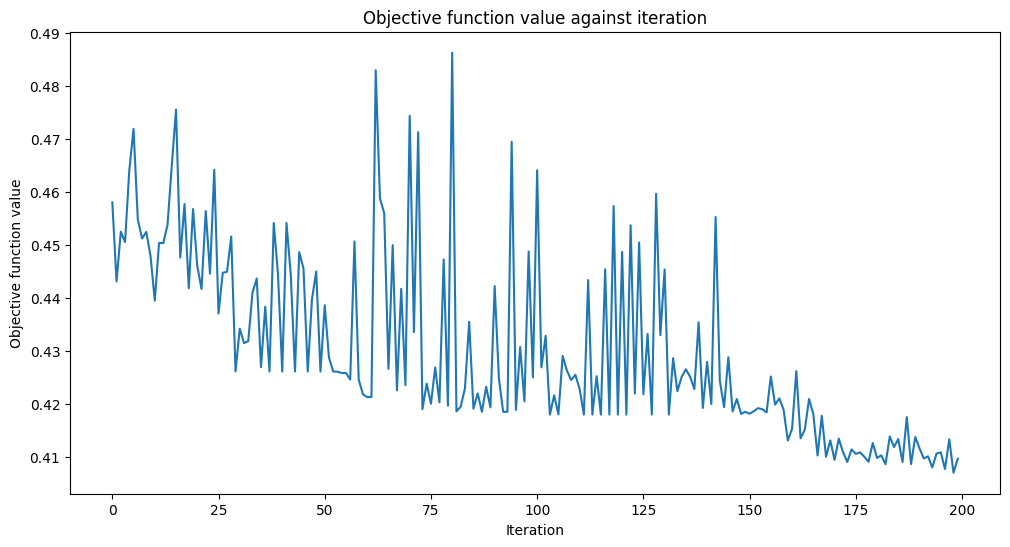

Accuracy from the train data: 41.21%
Accuracy from the test data: 41.58%


In [10]:
# Define callback for training visualization
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

# Load initial point
initial_point = np.random.rand(len(qnn.weight_params))

# Create classifier
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=200),
    callback=callback_graph,
    initial_point=initial_point,
)

# Objective function values for plotting
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# Fit classifier
classifier.fit(x_train, y_train)

# Score classifier
train_accuracy = classifier.score(x_train, y_train)
test_accuracy = classifier.score(x_test, y_test)

print(f"Accuracy from the train data: {np.round(100 * train_accuracy, 2)}%")
print(f"Accuracy from the test data: {np.round(100 * test_accuracy, 2)}%")


# Imbalanced data

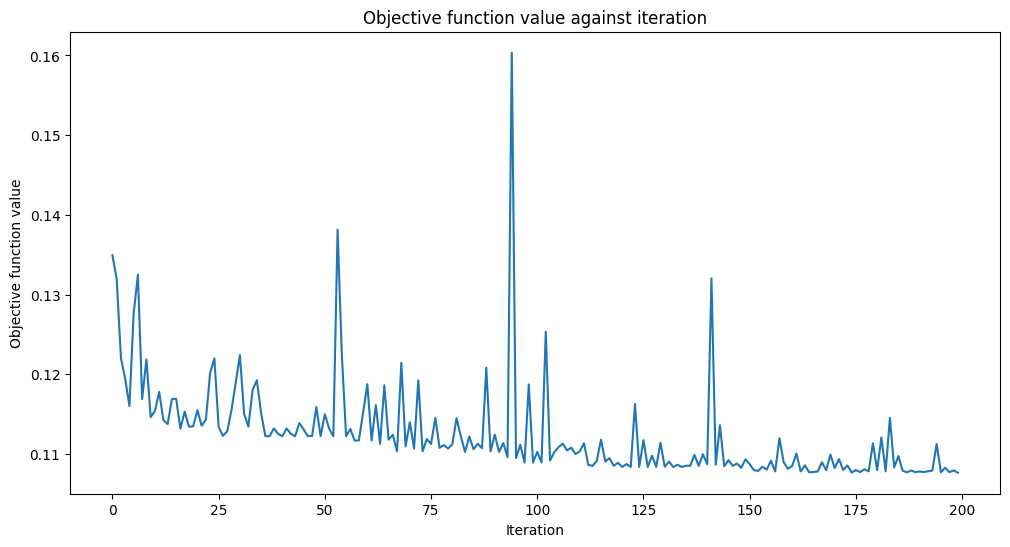

Accuracy from the train data: 9.96%
Accuracy from the test data: 83.81%


In [12]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import numpy as np

# Define paths to your data
train_data_path = '/home/kundan/Documents/quantum/IM_data/train/'
test_data_path = '/home/kundan/Documents/quantum/IM_data/test/'

# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets using ImageFolder
train_dataset = datasets.ImageFolder(train_data_path, transform=transform)
test_dataset = datasets.ImageFolder(test_data_path, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check the class labels
print(train_dataset.classes)

# Function to convert image tensors to numpy arrays
def convert_to_numpy(dataloader):
    images = []
    labels = []
    for data in dataloader:
        img, label = data
        img = img.numpy()
        img = img.reshape(img.shape[0], -1)  # Flatten the images
        images.append(img)
        labels.append(label)
    return np.concatenate(images), np.concatenate(labels)

# Convert train and test data to numpy arrays
x_train, y_train = convert_to_numpy(train_loader)
x_test, y_test = convert_to_numpy(test_loader)

# Normalize the data
x_train = (x_train - np.min(x_train)) / (np.max(x_train) - np.min(x_train))
x_test = (x_test - np.min(x_test)) / (np.max(x_test) - np.min(x_test))

# Ensure data dimensions are suitable for the quantum circuits
x_train = x_train[:, :8]
x_test = x_test[:, :8]
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN

# Define convolutional circuit
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

# Define convolutional layer
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

# Define pooling circuit
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    return target

# Define pooling layer
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

# Create feature map and ansatz
feature_map = ZFeatureMap(8)
ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

# Observable
observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# Decompose circuit for QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)
# Define callback for training visualization
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

# Load initial point
initial_point = np.random.rand(len(qnn.weight_params))

# Create classifier
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=200),
    callback=callback_graph,
    initial_point=initial_point,
)

# Objective function values for plotting
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# Fit classifier
classifier.fit(x_train, y_train)

# Score classifier
train_accuracy = classifier.score(x_train, y_train)
test_accuracy = classifier.score(x_test, y_test)

print(f"Accuracy from the train data: {np.round(100 * train_accuracy, 2)}%")
print(f"Accuracy from the test data: {np.round(100 * test_accuracy, 2)}%")

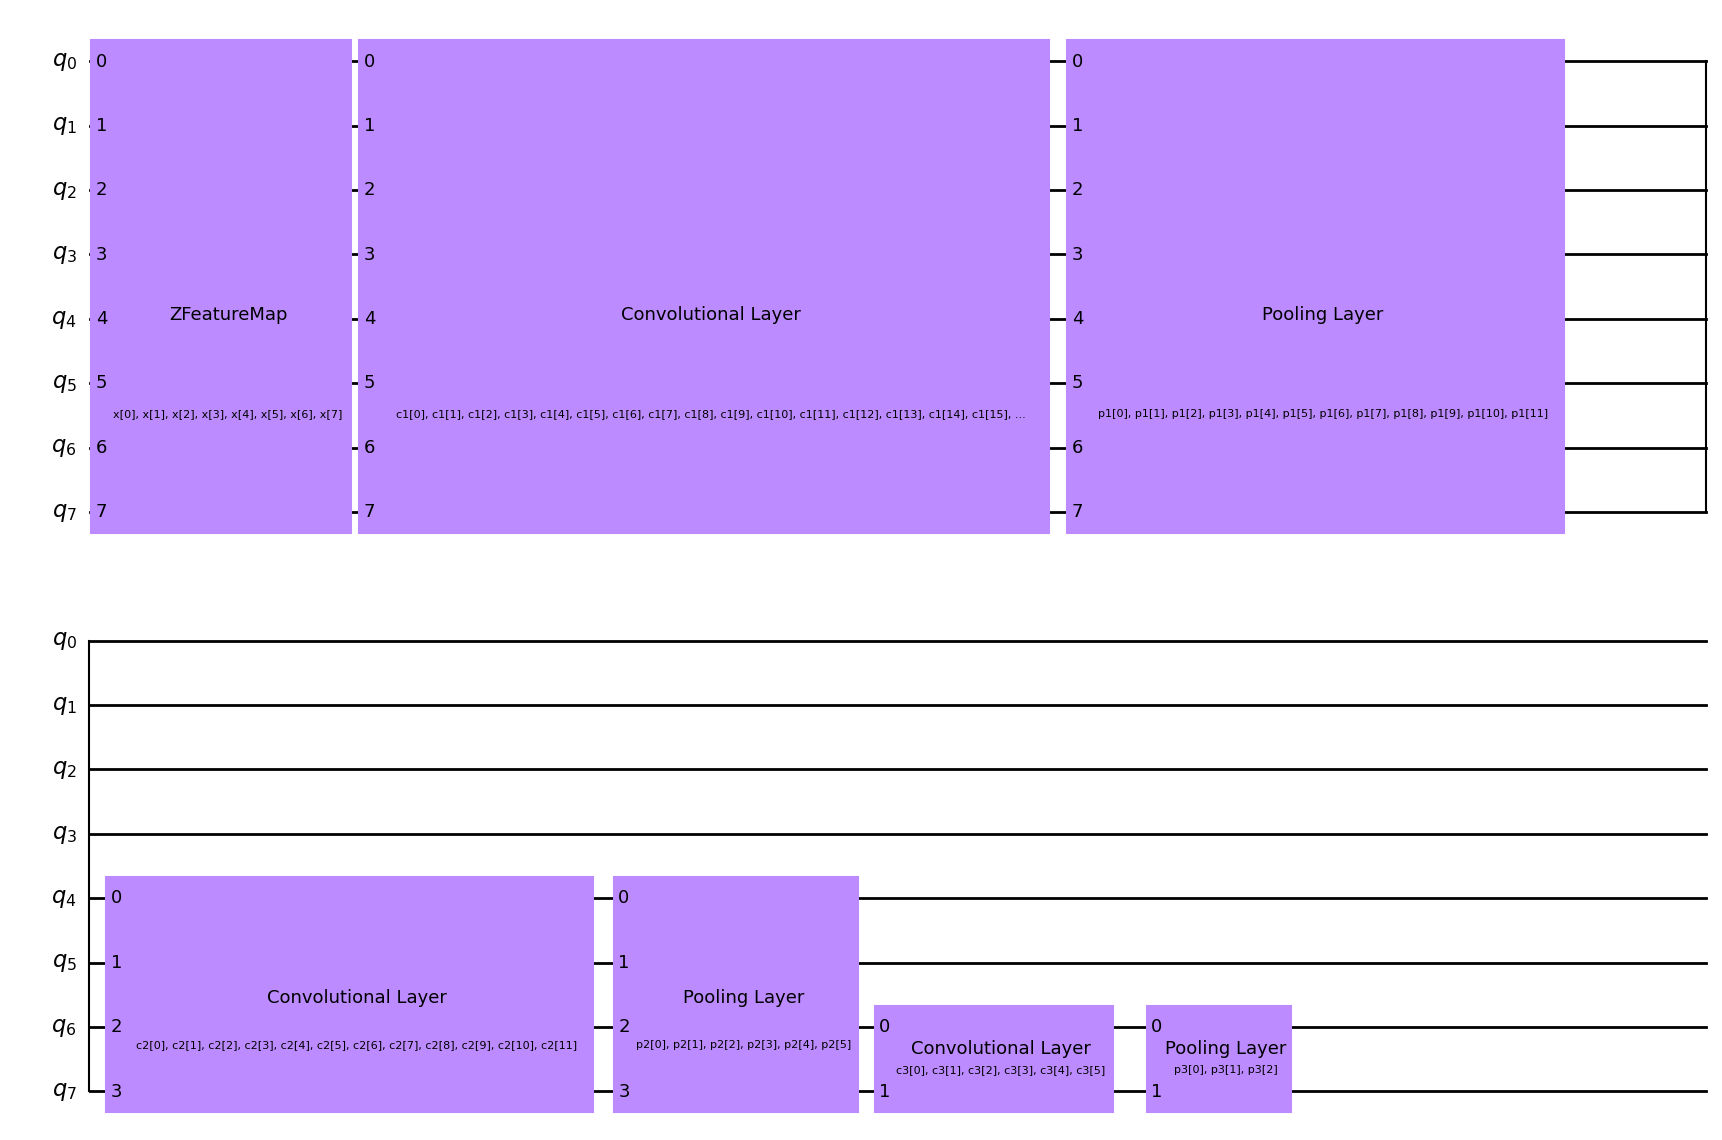

In [1]:

# from qiskit import QuantumCircuit
# from qiskit.circuit import ParameterVector
# from qiskit.circuit.library import ZFeatureMap
# from qiskit.quantum_info import SparsePauliOp
# from qiskit.algorithms.optimizers import COBYLA
# from qiskit.utils import algorithm_globals
# from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
# from qiskit_machine_learning.neural_networks import EstimatorQNN

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score
import os
from PIL import Image
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split

# We now define a two qubit unitary as defined in [3]
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl", style="clifford")
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl", style="clifford")
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")
feature_map = ZFeatureMap(8)
feature_map.decompose().draw("mpl", style="clifford")

feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)
circuit.draw("mpl", style="clifford")

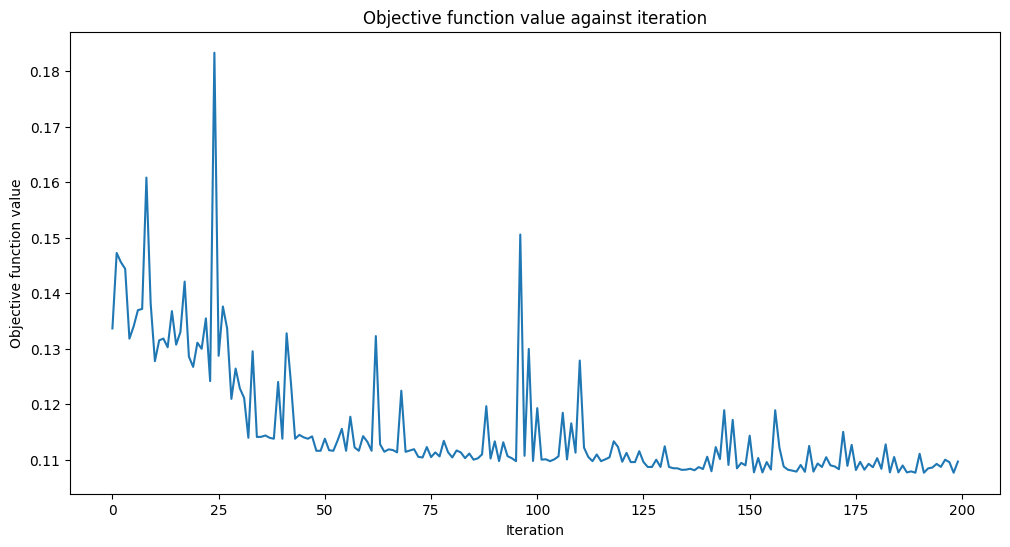

Accuracy from the train data: 9.58%
Accuracy from the test data: 44.06%

Actual vs. Predicted labels:
Actual: 0, Predicted: [1.]
Actual: 0, Predicted: [1.]
Actual: 0, Predicted: [-1.]
Actual: 0, Predicted: [1.]
Actual: 0, Predicted: [1.]
Actual: 0, Predicted: [1.]
Actual: 0, Predicted: [1.]
Actual: 0, Predicted: [1.]
Actual: 0, Predicted: [1.]
Actual: 0, Predicted: [1.]
Actual: 0, Predicted: [1.]
Actual: 0, Predicted: [1.]
Actual: 0, Predicted: [1.]
Actual: 0, Predicted: [1.]
Actual: 0, Predicted: [1.]
Actual: 0, Predicted: [1.]
Actual: 0, Predicted: [1.]
Actual: 0, Predicted: [-1.]
Actual: 0, Predicted: [1.]
Actual: 0, Predicted: [1.]
Actual: 0, Predicted: [1.]
Actual: 0, Predicted: [1.]
Actual: 0, Predicted: [-1.]
Actual: 0, Predicted: [1.]
Actual: 0, Predicted: [1.]
Actual: 0, Predicted: [1.]
Actual: 0, Predicted: [1.]
Actual: 0, Predicted: [1.]
Actual: 0, Predicted: [1.]
Actual: 0, Predicted: [1.]
Actual: 0, Predicted: [-1.]
Actual: 0, Predicted: [1.]
Actual: 0, Predicted: [1.]
Act

In [14]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN

# Define paths to your data
train_data_path = '/home/kundan/Documents/quantum/IM_data/train/'
test_data_path = '/home/kundan/Documents/quantum/MY_data/test/'

# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets using ImageFolder
train_dataset = datasets.ImageFolder(train_data_path, transform=transform)
test_dataset = datasets.ImageFolder(test_data_path, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check the class labels
print(train_dataset.classes)

# Function to convert image tensors to numpy arrays
def convert_to_numpy(dataloader):
    images = []
    labels = []
    for data in dataloader:
        img, label = data
        img = img.numpy()
        img = img.reshape(img.shape[0], -1)  # Flatten the images
        images.append(img)
        labels.append(label)
    return np.concatenate(images), np.concatenate(labels)

# Convert train and test data to numpy arrays
x_train, y_train = convert_to_numpy(train_loader)
x_test, y_test = convert_to_numpy(test_loader)

# Normalize the data
x_train = (x_train - np.min(x_train)) / (np.max(x_train) - np.min(x_train))
x_test = (x_test - np.min(x_test)) / (np.max(x_test) - np.min(x_test))

# Ensure data dimensions are suitable for the quantum circuits
x_train = x_train[:, :8]
x_test = x_test[:, :8]

# Define convolutional circuit
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

# Define convolutional layer
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

# Define pooling circuit
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    return target

# Define pooling layer
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

# Create feature map and ansatz
feature_map = ZFeatureMap(8)
ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

# Observable
observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# Decompose circuit for QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

# Define callback for training visualization
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

# Load initial point
initial_point = np.random.rand(len(qnn.weight_params))

# Create classifier
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=200),
    callback=callback_graph,
    initial_point=initial_point,
)

# Objective function values for plotting
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# Fit classifier
classifier.fit(x_train, y_train)

# Score classifier
train_accuracy = classifier.score(x_train, y_train)
test_accuracy = classifier.score(x_test, y_test)

print(f"Accuracy from the train data: {np.round(100 * train_accuracy, 2)}%")
print(f"Accuracy from the test data: {np.round(100 * test_accuracy, 2)}%")

# Predict on test data
y_pred = classifier.predict(x_test)

# Print actual vs. predicted labels
print("\nActual vs. Predicted labels:")
for actual, pred in zip(y_test, y_pred):
    print(f"Actual: {actual}, Predicted: {pred}")


In [24]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN

# Define paths to your data
train_data_path = '/home/kundan/Documents/quantum/my_data/train/'
test_data_path = '/home/kundan/Documents/quantum/my_data/test/'

# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets using ImageFolder
train_dataset = datasets.ImageFolder(train_data_path, transform=transform)
test_dataset = datasets.ImageFolder(test_data_path, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check the class labels
print(train_dataset.classes)


['Apple', 'Banana', 'avocado', 'cherry', 'kiwi', 'mango', 'orange', 'pinenapple', 'strawberries', 'watermelon']


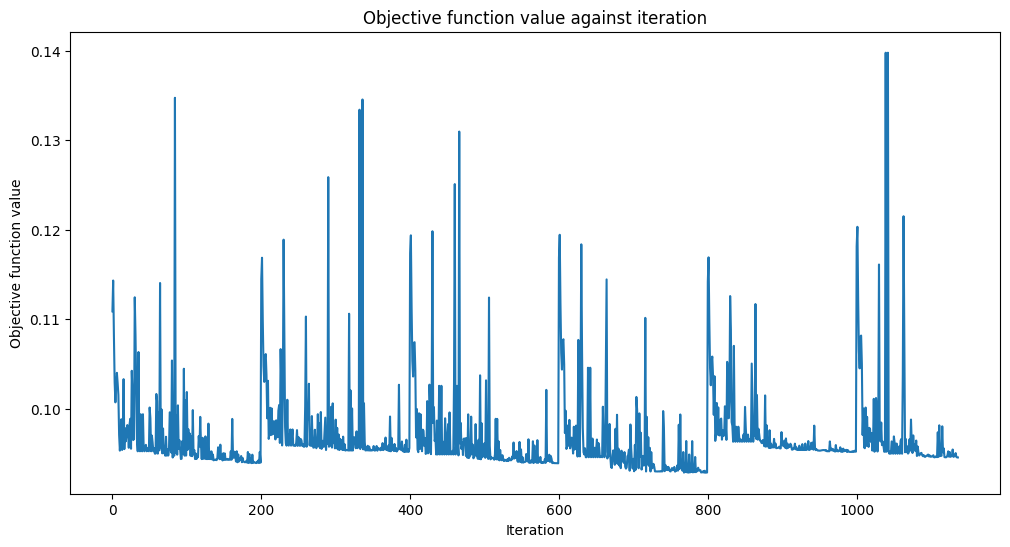

In [ ]:

# Function to convert image tensors to numpy arrays
def convert_to_numpy(dataloader):
    images = []
    labels = []
    for data in dataloader:
        img, label = data
        img = img.numpy()
        img = img.reshape(img.shape[0], -1)  # Flatten the images
        images.append(img)
        labels.append(label)
    return np.concatenate(images), np.concatenate(labels)

# Convert train and test data to numpy arrays
x_train, y_train = convert_to_numpy(train_loader)
x_test, y_test = convert_to_numpy(test_loader)

# Normalize the data
x_train = (x_train - np.min(x_train)) / (np.max(x_train) - np.min(x_train))
x_test = (x_test - np.min(x_test)) / (np.max(x_test) - np.min(x_test))

# Ensure data dimensions are suitable for the quantum circuits
x_train = x_train[:, :8]
x_test = x_test[:, :8]

# Define convolutional circuit
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

# Define convolutional layer
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

# Define pooling circuit
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    return target

# Define pooling layer
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

# Create feature map and ansatz
feature_map = ZFeatureMap(8)
ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

# Modify the observable for multi-class classification
num_classes = len(train_dataset.classes)
observables = [SparsePauliOp.from_list([("Z" + "I" * 7, 1)]) for _ in range(num_classes)]

# Create a QNN for each class
qnns = [EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
) for observable in observables]

# Define callback for training visualization
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

# Load initial point
initial_point = np.random.rand(len(qnns[0].weight_params))

# Create multi-class classifier
class MultiClassQuantumClassifier:
    def __init__(self, qnns, optimizer, callback, initial_point):
        self.classifiers = [NeuralNetworkClassifier(
            qnn,
            optimizer=optimizer,
            callback=callback,
            initial_point=initial_point
        ) for qnn in qnns]

    def fit(self, X, y):
        for i, classifier in enumerate(self.classifiers):
            y_binary = (y == i).astype(int)
            classifier.fit(X, y_binary)

    def predict(self, X):
        predictions = np.array([classifier.predict(X) for classifier in self.classifiers])
        return np.argmax(predictions, axis=0)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

# Create multi-class classifier
classifier = MultiClassQuantumClassifier(
    qnns,
    optimizer=COBYLA(maxiter=200),
    callback=callback_graph,
    initial_point=initial_point,
)

# Objective function values for plotting
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# Fit classifier
classifier.fit(x_train, y_train)

# Score classifier
train_accuracy = classifier.score(x_train, y_train)
test_accuracy = classifier.score(x_test, y_test)

print(f"Accuracy from the train data: {np.round(100 * train_accuracy, 2)}%")
print(f"Accuracy from the test data: {np.round(100 * test_accuracy, 2)}%")

# Predict on test data
y_pred = classifier.predict(x_test)

# Print actual vs. predicted labels
print("\nActual vs. Predicted labels:")
for actual, pred in zip(y_test, y_pred):
    print(f"Actual: {actual}, Predicted: {pred}")

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN

# Define paths to your data
train_data_path = '/home/kundan/Documents/quantum/data/train_reduced/'
test_data_path = '/home/kundan/Documents/quantum/data/test_reduced/'

# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets using ImageFolder
train_dataset = datasets.ImageFolder(train_data_path, transform=transform)
test_dataset = datasets.ImageFolder(test_data_path, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check the class labels
print(train_dataset.classes)


['apple', 'avocado', 'banana', 'cherry', 'kiwi', 'mango', 'orange', 'pinenapple', 'strawberries', 'watermelon']


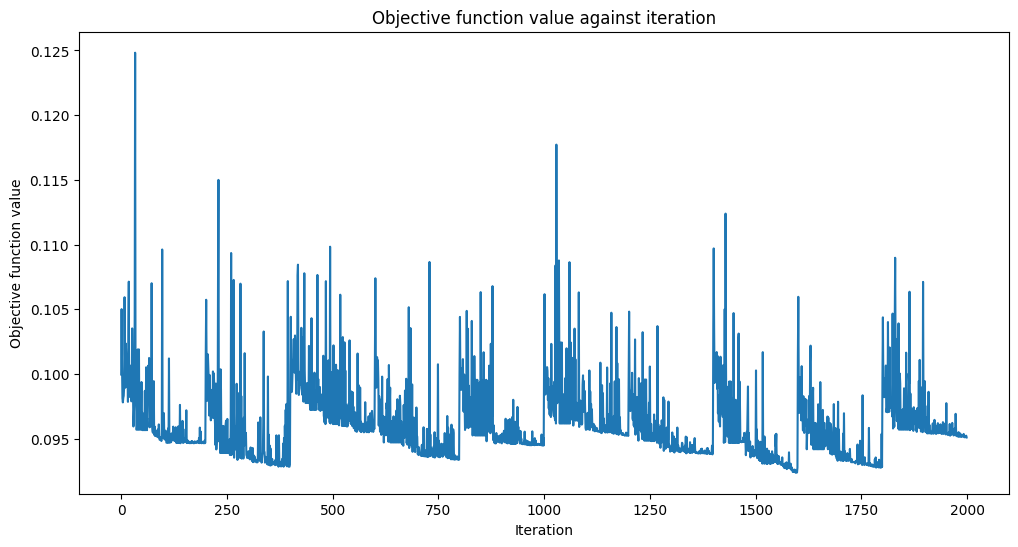

Accuracy from the train data: 10.0%
Accuracy from the test data: 10.0%

Actual vs. Predicted labels:
Actual: 0, Predicted: [0]
Actual: 0, Predicted: [0]
Actual: 0, Predicted: [0]
Actual: 0, Predicted: [1]
Actual: 0, Predicted: [0]
Actual: 0, Predicted: [0]
Actual: 0, Predicted: [0]
Actual: 0, Predicted: [0]
Actual: 0, Predicted: [0]
Actual: 0, Predicted: [1]
Actual: 0, Predicted: [0]
Actual: 0, Predicted: [1]
Actual: 0, Predicted: [0]
Actual: 0, Predicted: [0]
Actual: 0, Predicted: [0]
Actual: 0, Predicted: [1]
Actual: 0, Predicted: [0]
Actual: 0, Predicted: [0]
Actual: 0, Predicted: [0]
Actual: 0, Predicted: [0]
Actual: 0, Predicted: [0]
Actual: 0, Predicted: [1]
Actual: 0, Predicted: [0]
Actual: 0, Predicted: [0]
Actual: 0, Predicted: [0]
Actual: 0, Predicted: [5]
Actual: 0, Predicted: [0]
Actual: 0, Predicted: [0]
Actual: 0, Predicted: [0]
Actual: 0, Predicted: [0]
Actual: 0, Predicted: [0]
Actual: 0, Predicted: [1]
Actual: 0, Predicted: [1]
Actual: 0, Predicted: [1]
Actual: 0, Pred

In [3]:

# Function to convert image tensors to numpy arrays
def convert_to_numpy(dataloader):
    images = []
    labels = []
    for data in dataloader:
        img, label = data
        img = img.numpy()
        img = img.reshape(img.shape[0], -1)  # Flatten the images
        images.append(img)
        labels.append(label)
    return np.concatenate(images), np.concatenate(labels)

# Convert train and test data to numpy arrays
x_train, y_train = convert_to_numpy(train_loader)
x_test, y_test = convert_to_numpy(test_loader)

# Normalize the data
x_train = (x_train - np.min(x_train)) / (np.max(x_train) - np.min(x_train))
x_test = (x_test - np.min(x_test)) / (np.max(x_test) - np.min(x_test))

# Ensure data dimensions are suitable for the quantum circuits
x_train = x_train[:, :8]
x_test = x_test[:, :8]

# Define convolutional circuit
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

# Define convolutional layer
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

# Define pooling circuit
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    return target

# Define pooling layer
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

# Create feature map and ansatz
feature_map = ZFeatureMap(8)
ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

# Modify the observable for multi-class classification
num_classes = len(train_dataset.classes)
observables = [SparsePauliOp.from_list([("Z" + "I" * 7, 1)]) for _ in range(num_classes)]

# Create a QNN for each class
qnns = [EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
) for observable in observables]

# Define callback for training visualization
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

# Load initial point
initial_point = np.random.rand(len(qnns[0].weight_params))

# Create multi-class classifier
class MultiClassQuantumClassifier:
    def __init__(self, qnns, optimizer, callback, initial_point):
        self.classifiers = [NeuralNetworkClassifier(
            qnn,
            optimizer=optimizer,
            callback=callback,
            initial_point=initial_point
        ) for qnn in qnns]

    def fit(self, X, y):
        for i, classifier in enumerate(self.classifiers):
            y_binary = (y == i).astype(int)
            classifier.fit(X, y_binary)

    def predict(self, X):
        predictions = np.array([classifier.predict(X) for classifier in self.classifiers])
        return np.argmax(predictions, axis=0)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

# Create multi-class classifier
classifier = MultiClassQuantumClassifier(
    qnns,
    optimizer=COBYLA(maxiter=200),
    callback=callback_graph,
    initial_point=initial_point,
)

# Objective function values for plotting
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# Fit classifier
classifier.fit(x_train, y_train)

# Score classifier
train_accuracy = classifier.score(x_train, y_train)
test_accuracy = classifier.score(x_test, y_test)

print(f"Accuracy from the train data: {np.round(100 * train_accuracy, 2)}%")
print(f"Accuracy from the test data: {np.round(100 * test_accuracy, 2)}%")

# Predict on test data
y_pred = classifier.predict(x_test)

# Print actual vs. predicted labels
print("\nActual vs. Predicted labels:")
for actual, pred in zip(y_test, y_pred):
    print(f"Actual: {actual}, Predicted: {pred}")

In [9]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from qiskit.circuit.library import ZFeatureMap
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit_algorithms.optimizers import COBYLA
import matplotlib.pyplot as plt
from IPython.display import clear_output

class QuantumConvolutionalClassifier:
    def __init__(self, train_path, test_path, batch_size=32, num_qubits=8):
        self.train_path = train_path
        self.test_path = test_path
        self.batch_size = batch_size
        self.num_qubits = num_qubits
        self.classifier = None
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_test = None
        self.classes = None

    def load_data(self):
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        train_dataset = datasets.ImageFolder(self.train_path, transform=transform)
        test_dataset = datasets.ImageFolder(self.test_path, transform=transform)

        self.classes = train_dataset.classes
        print(f"Class labels: {self.classes}")

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

        self.x_train, self.y_train = self.convert_to_numpy(train_loader)
        self.x_test, self.y_test = self.convert_to_numpy(test_loader)

        # Normalize the data
        self.x_train = (self.x_train - np.min(self.x_train)) / (np.max(self.x_train) - np.min(self.x_train))
        self.x_test = (self.x_test - np.min(self.x_test)) / (np.max(self.x_test) - np.min(self.x_test))

        # Ensure data dimensions are suitable for the quantum circuits
        self.x_train = self.x_train[:, :self.num_qubits]
        self.x_test = self.x_test[:, :self.num_qubits]

    @staticmethod
    def convert_to_numpy(dataloader):
        images = []
        labels = []
        for data in dataloader:
            img, label = data
            img = img.numpy()
            img = img.reshape(img.shape[0], -1)  # Flatten the images
            images.append(img)
            labels.append(label)
        return np.concatenate(images), np.concatenate(labels)

    def create_circuit(self):
        feature_map = ZFeatureMap(self.num_qubits)
        ansatz = QuantumCircuit(self.num_qubits, name="Ansatz")

        # First Convolutional Layer
        ansatz.compose(self.conv_layer(self.num_qubits, "c1"), list(range(self.num_qubits)), inplace=True)

        # First Pooling Layer
        ansatz.compose(self.pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(self.num_qubits)), inplace=True)

        # Second Convolutional Layer
        ansatz.compose(self.conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

        # Second Pooling Layer
        ansatz.compose(self.pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

        # Third Convolutional Layer
        ansatz.compose(self.conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

        # Third Pooling Layer
        ansatz.compose(self.pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

        # Combining the feature map and ansatz
        circuit = QuantumCircuit(self.num_qubits)
        circuit.compose(feature_map, range(self.num_qubits), inplace=True)
        circuit.compose(ansatz, range(self.num_qubits), inplace=True)

        return circuit, feature_map, ansatz

    @staticmethod
    def conv_layer(num_qubits, param_prefix):
        qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
        qubits = list(range(num_qubits))
        param_index = 0
        params = ParameterVector(param_prefix, length=num_qubits * 3)
        for q1, q2 in zip(qubits[0::2], qubits[1::2]):
            qc = qc.compose(QuantumConvolutionalClassifier.conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
            qc.barrier()
            param_index += 3
        for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
            qc = qc.compose(QuantumConvolutionalClassifier.conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
            qc.barrier()
            param_index += 3

        qc_inst = qc.to_instruction()

        qc = QuantumCircuit(num_qubits)
        qc.append(qc_inst, qubits)
        return qc

    @staticmethod
    def conv_circuit(params):
        target = QuantumCircuit(2)
        target.rz(-np.pi / 2, 1)
        target.cx(1, 0)
        target.rz(params[0], 0)
        target.ry(params[1], 1)
        target.cx(0, 1)
        target.ry(params[2], 1)
        target.cx(1, 0)
        target.rz(np.pi / 2, 0)
        return target

    @staticmethod
    def pool_layer(sources, sinks, param_prefix):
        num_qubits = len(sources) + len(sinks)
        qc = QuantumCircuit(num_qubits, name="Pooling Layer")
        param_index = 0
        params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
        for source, sink in zip(sources, sinks):
            qc = qc.compose(QuantumConvolutionalClassifier.pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
            qc.barrier()
            param_index += 3

        qc_inst = qc.to_instruction()

        qc = QuantumCircuit(num_qubits)
        qc.append(qc_inst, range(num_qubits))
        return qc

    @staticmethod
    def pool_circuit(params):
        target = QuantumCircuit(2)
        target.rz(-np.pi / 2, 1)
        target.cx(1, 0)
        target.rz(params[0], 0)
        target.ry(params[1], 1)
        target.cx(0, 1)
        target.ry(params[2], 1)
        return target

    def create_classifier(self):
        circuit, feature_map, ansatz = self.create_circuit()

        num_classes = len(self.classes)
        observables = [SparsePauliOp.from_list([("Z" + "I" * (self.num_qubits - 1), 1)]) for _ in range(num_classes)]

        qnns = [EstimatorQNN(
            circuit=circuit.decompose(),
            observables=observable,
            input_params=feature_map.parameters,
            weight_params=ansatz.parameters,
        ) for observable in observables]

        initial_point = np.random.rand(len(qnns[0].weight_params))

        self.classifier = MultiClassQuantumClassifier(
            qnns,
            optimizer=COBYLA(maxiter=200),
            callback=self.callback_graph,
            initial_point=initial_point,
        )

    def train(self):
        self.classifier.fit(self.x_train, self.y_train)

    def evaluate(self):
        train_accuracy = self.classifier.score(self.x_train, self.y_train)
        test_accuracy = self.classifier.score(self.x_test, self.y_test)

        print(f"Accuracy from the train data: {np.round(100 * train_accuracy, 2)}%")
        print(f"Accuracy from the test data: {np.round(100 * test_accuracy, 2)}%")

        y_pred = self.classifier.predict(self.x_test)

        print("\nActual vs. Predicted labels:")
        for actual, pred in zip(self.y_test, y_pred):
            print(f"Actual: {self.classes[actual]}, Predicted: {self.classes[pred]}")

    @staticmethod
    def callback_graph(weights, obj_func_eval):
        clear_output(wait=True)
        QuantumConvolutionalClassifier.objective_func_vals.append(obj_func_eval)
        plt.title("Objective function value against iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Objective function value")
        plt.plot(range(len(QuantumConvolutionalClassifier.objective_func_vals)), QuantumConvolutionalClassifier.objective_func_vals)
        plt.show()

    objective_func_vals = []

class MultiClassQuantumClassifier:
    def __init__(self, qnns, optimizer, callback, initial_point):
        self.classifiers = [NeuralNetworkClassifier(
            qnn,
            optimizer=optimizer,
            callback=callback,
            initial_point=initial_point
        ) for qnn in qnns]

    def fit(self, X, y):
        for i, classifier in enumerate(self.classifiers):
            y_binary = (y == i).astype(int)
            classifier.fit(X, y_binary)

    def predict(self, X):
        predictions = np.array([classifier.predict(X) for classifier in self.classifiers])
        return np.argmax(predictions, axis=0)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)


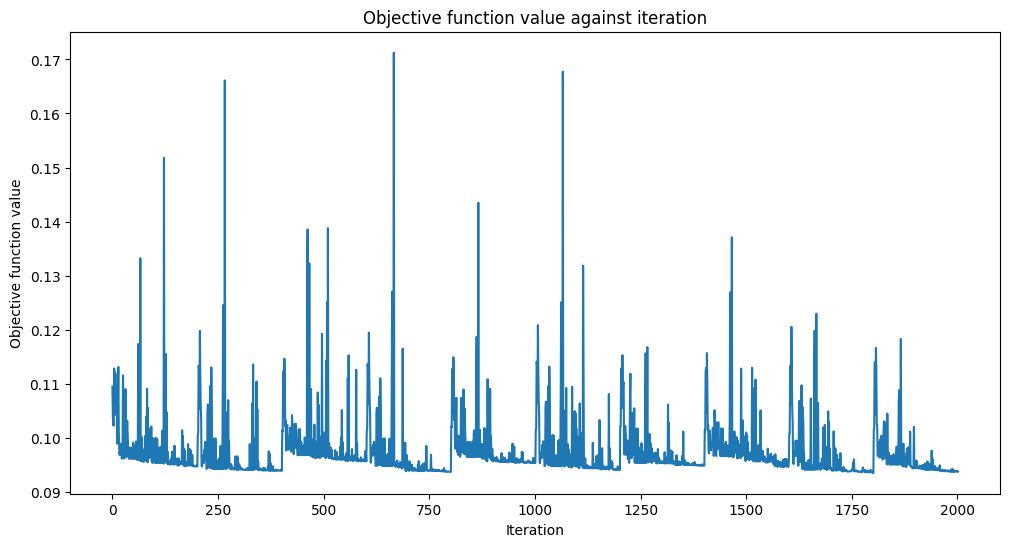

Accuracy from the train data: 10.0%
Accuracy from the test data: 10.0%

Actual vs. Predicted labels:


TypeError: only integer scalar arrays can be converted to a scalar index

In [11]:
plt.rcParams["figure.figsize"] = (12, 6)
# Paths to your datasets
train_data_path = '/home/kundan/Documents/quantum/my_data/train/'
test_data_path = '/home/kundan/Documents/quantum/my_data/test_reduced/'
# Create an instance of the classifier
qcc = QuantumConvolutionalClassifier(train_path=train_data_path, test_path=test_data_path)
# Load and preprocess the data
qcc.load_data()
# Create the quantum circuit and classifier
qcc.create_classifier()
# Train the classifier
qcc.train()
# Evaluate the classifier
qcc.evaluate()